In [1]:
from netCDF4 import Dataset
from skimage import filters
import torch.nn as nn
import netCDF4 as nc
import pandas as pd
import numpy as np
import random
import torch
import os
import matplotlib.pyplot as plt
from models.forecastors.GeneralUnet.general_unet import *
from models.forecastors.utils.loss import * 
import torch.optim as optim
from models.utils.configtrain import *
from data_prep.config.env import *
from skimage.transform import rotate

/home/resifis/anaconda3/envs/kaustenv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def setup_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)  # cpu
    torch.cuda.manual_seed_all(seed)  
    torch.backends.cudnn.deterministic = True  
    torch.backends.cudnn.benchmark = True 
setup_seed(30)

In [3]:
import matplotlib.pyplot as plt
from netCDF4 import Dataset
from skimage import filters
import torch.nn as nn
import netCDF4 as nc
import pandas as pd
import numpy as np
import random
import torch
import os
from skimage import filters
from skimage.util import random_noise


DATAPATH = os.environ.get("DATAPATH","/home/resifis/Desktop/kaustcode/Packages/processed_clean_data")



class Dataset2D():
    def __init__(self,solar_type,data_type = "Train"):
        self.solar_type  = "DHI"
        self.hcloud = Dataset2D._read_data("hcloud")
        self.mcloud = Dataset2D._read_data("mcloud")
        self.lcloud = Dataset2D._read_data("lcloud")
        self.water_vapor = Dataset2D._read_data("water_vapor")
        self.ozone = Dataset2D._read_data("ozone")
        self.aerosol = Dataset2D._read_data("aerosol")
        self.len = 48222
        self.solar_type = solar_type
        self.target_data = Dataset2D._read_target(self.solar_type)
        self.output = dict()
        self.eps = 1e-5
        
    
    @staticmethod
    def _read_data(data_type):
        if data_type == "hcloud":
            hcloud = Dataset(os.path.join(DATAPATH,"hcloud.nc"))
            return hcloud
        elif data_type == "mcloud":
            mcloud = Dataset(os.path.join(DATAPATH,"mcloud.nc"))
            return mcloud
        elif data_type == "lcloud":
            lcloud = Dataset(os.path.join(DATAPATH,"lcloud.nc"))
            return lcloud
        elif data_type == "water_vapor":
            water_vapor = Dataset(os.path.join(DATAPATH,"water_vapor_new.nc"))
            return water_vapor
        elif data_type == "ozone":
            ozone = Dataset(os.path.join(DATAPATH,"ozone.nc"))
            return ozone
        else:
            aerosol = Dataset(os.path.join(DATAPATH,"aod.nc"))
            return aerosol
    @staticmethod
    def _read_target(target_type):
        if target_type == "GHI":
            GHI = Dataset(os.path.join(DATAPATH,"ghi.nc"))
            return GHI
        elif target_type == "DHI":
            DHI = Dataset(os.path.join(DATAPATH,"dhi.nc"))
            return DHI
        else :
            DNI = Dataset(os.path.join(DATAPATH,"dni.nc"))
            return DNI
        
        
    @staticmethod
    def _filtering(list_data):
        data = list_data.copy()
        list_tensors = []
        for i in range(len(data)):
            arr = filters.sobel(np.array(data[i]))
            list_tensors.append(torch.tensor(arr,dtype = torch.float))
        return list_tensors
    @staticmethod
    def _augment_data(list_data):
        train_data = []
        for i in range(len(list_data)):
            arr = np.array(list_data[i])
            train_data.append(arr)
            train_data.append(rotate(arr, angle=45, mode = 'wrap'))
            train_data.append(np.fliplr(arr))
            train_data.append(np.flipud(arr))
            train_data.append(random_noise(arr,var=0.2**2))
            
        for i in range(len(train_data)):
            train_data[i] = torch.tensor(np.array(train_data[i]),dtype = torch.float).unsqueeze(0)

        out = torch.cat(train_data,dim = 0)
        return out 
        
    
    def _get_tensors(self,item):
        all_data = []
        data_hcloud =  torch.tensor(self.hcloud.variables["cc"][item,:,:],dtype = torch.float)
        data_mcloud =  torch.tensor(self.mcloud.variables["cc"][item,:,:],dtype = torch.float)
        data_lcloud =  torch.tensor(self.lcloud.variables["cc"][item,:,:],dtype = torch.float)
        data_aerosol = torch.tensor(self.aerosol.variables["aod5503d"][item,:,:],dtype = torch.float)
        data_ozone =   torch.tensor(self.ozone.variables["o3rad"][item,:,:],dtype = torch.float)
        data_water_vapor = torch.tensor(self.water_vapor.variables["qvapor"][item,:,:],dtype = torch.float)
        
        
        
        
        all_data.extend([torch.flip(data_hcloud,dims = [0])/(data_hcloud.max()+self.eps),
                         torch.flip(data_mcloud,dims = [0])/(data_mcloud.max()+self.eps),
                         torch.flip(data_lcloud,dims = [0])/(data_lcloud.max()+self.eps),
                         torch.flip(data_aerosol,dims = [0])/(data_aerosol.max()+self.eps),
                         torch.flip(data_ozone,dims = [0])/(data_ozone.max()+self.eps),
                         torch.flip(data_water_vapor,dims = [0])/(data_water_vapor.max()+self.eps),
                        ])
        final_data = []
        final_data = Dataset2D._augment_data(all_data)
            
        #filtered = Dataset2D._filtering(all_data)
        #all_data.extend(filtered)
        target = torch.tensor(self.target_data.variables[self.solar_type.lower()][item],dtype = torch.float)
        target = torch.flip(target,dims = [0])
        return final_data,target
        
    def __len__(self):
        return self.len
    
    
    def __getitem__(self,item):
        out = dict()
        all_data,target = self._get_tensors(item)
        out['data'] = all_data
        out['target'] = target/target.max()
        return out
        

In [4]:
DataSet = Dataset2D("GHI")

In [5]:
input_features = 30
output_feature = 1
model = UNet2D(in_channels = input_features,
               out_channels = output_feature,
            )

def init_weights(m):
    if isinstance(m,nn.Conv2d):
        torch.nn.init.normal_(m.weight)
        m.bias.data.fill_(1)
    if isinstance(m,nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight)
        m.bias.data.fill_(1)
    if isinstance(m,nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight)
        m.bias.data.fill_(1)
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(1)

criterion = nn.MSELoss()
device = "cuda:0" if torch.cuda.is_available() else "cpu"
criterion = criterion.to(device)
model = model.to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       factor = 0.2,
                                                       patience = 10,
                                                       verbose = True)

shuffle_trainloader = False
train_batch_size = 6
shuffle_validloader = False
valid_batch_size = 6
epochs = 100
verbose = True

In [6]:
criterion

MSELoss()

In [7]:
from tqdm import tqdm
import torch
import os
from tqdm import tqdm
import torch.nn as nn
import torchvision
import neptune.new as neptune
from neptune.new.types import File
import torch.nn.init as weight_init
from torch.utils.data import RandomSampler
import matplotlib.pyplot as plt
plt.style.use('classic')





MODELS_WEIGHTS = os.environ.get("MODELS_WEIGHTS","/home/resifis/Desktop/kaustcode/Packages/weights2d")


class AverageMeter:
    """
    Computes and stores the average and current value
    """

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


class Training():
    def __init__(self):
        self.aa = 1
        
    def _initialize_weights(self,net):
        for name, param in net.named_parameters(): 
            weight_init.normal_(param)
        
    def train_fn(self,model,train_loader):
        model.train()
        
        tr_loss = 0
        counter = 0
        losses = AverageMeter()
        tqt = tqdm(enumerate(train_loader),total = len(train_loader))
        for index,train_batch in tqt:
            list_sparse = []
            data = train_batch["data"].to(device)
            target = train_batch["target"].to(device)
            pred_target = model(data)
            pred_target = pred_target.squeeze(1)
            train_loss = criterion(pred_target,target)
            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()
            tr_loss += train_loss.item()        
            counter = counter + 1
            losses.update(train_loss.item(),pred_target.size(0))
            tqt.set_postfix(Loss = losses.avg, Batch_number = index )
        return tr_loss/counter

    def valid_fn(self,model,validation_loader):
        model.eval()
        val_loss = 0
        counter = 0
        losses = AverageMeter()
        tqt = tqdm(enumerate(validation_loader),total = len(validation_loader))
        with torch.no_grad():
            for index, valid_batch in tqt :
                list_sparse = []
                data = valid_batch["data"].to(device)
                target = valid_batch["target"].to(device)
                optimizer.zero_grad()
                pred_target = model(data)
                pred_target = pred_target.squeeze(1)
                validation_loss = criterion(pred_target,target)
                val_loss += validation_loss.item()        
                counter = counter + 1
                losses.update(validation_loss.item(),pred_target.size(0))
                tqt.set_postfix(loss = losses.avg, batch_number = index)
        return losses.avg
    
    
    
    @staticmethod
    def checkpoints(epoch,model,optimizer,loss):
        path = os.path.join(MODELS_WEIGHTS,f"epoch_{epoch}.pt")
        torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss,
                }, path)
        
    def get_dataloader(self,train_dataset,valid_dataset):

        train_sampler = RandomSampler(train_dataset,replacement = True,num_samples = 1500)
        valid_sampler = RandomSampler(valid_dataset,replacement = True,num_samples = 1000)

        train_data_loader = torch.utils.data.DataLoader(train_dataset,
                                                        shuffle = shuffle_trainloader,
                                                        batch_size = train_batch_size,
                                                        sampler = train_sampler,
                                                       )
        valid_data_loader = torch.utils.data.DataLoader(valid_dataset,
                                                        shuffle = shuffle_validloader,
                                                        batch_size = valid_batch_size,
                                                        sampler = valid_sampler,
                                                       )
        return train_data_loader,valid_data_loader
        
    def fit(self,model,train_dataset,valid_dataset):
        train_loss = []
        valid_loss = []
        best = 5000
        self._initialize_weights(model)
        model = model.apply(init_weights)
        for epoch in range(epochs):
            train_data_loader,valid_data_loader = self.get_dataloader(train_dataset,valid_dataset)
            if verbose :
                print(f".........EPOCH {epoch}........")
            tr_loss = self.train_fn(model,train_data_loader)
            train_loss.append(tr_loss)
            if verbose :
                print(f".........Train Loss = {tr_loss}........")
            val_loss = self.valid_fn(model,valid_data_loader)
            valid_loss.append(val_loss)
            Training.checkpoints(epoch,model,optimizer,val_loss)
            scheduler.step(val_loss)
            if verbose:
                print(f"...........Validation Loss = {val_loss}.......")

            if val_loss < best :
                best = val_loss
                patience = 0
            else:
                print("Score is not improving with patient = ",patience)
                patience +=1

            if patience >= epochs:
                print(f"Early Stopping on Epoch {epoch}")
                print(f"Best Loss = {best}")
                break
                
        
        PATH = os.path.join(MODELS_WEIGHTS,"model_2d.pth")
        torch.save(model.state_dict(),PATH)
        model.load_state_dict(torch.load(PATH))

In [8]:
job = Training()
job.fit(model,DataSet,DataSet)

.........EPOCH 0........


100%|███████████| 250/250 [03:03<00:00,  1.36it/s, Batch_number=249, Loss=0.207]


.........Train Loss = 0.20659096005931496........


100%|███████████| 167/167 [01:45<00:00,  1.58it/s, batch_number=166, loss=0.189]


...........Validation Loss = 0.1888845816962421.......
.........EPOCH 1........


100%|███████████| 250/250 [02:46<00:00,  1.50it/s, Batch_number=249, Loss=0.208]


.........Train Loss = 0.20836136659234764........


100%|███████████| 167/167 [01:41<00:00,  1.64it/s, batch_number=166, loss=0.199]


...........Validation Loss = 0.19888990359939634.......
Score is not improving with patient =  0
.........EPOCH 2........


100%|███████████| 250/250 [02:46<00:00,  1.50it/s, Batch_number=249, Loss=0.215]


.........Train Loss = 0.2147007873132825........


100%|███████████| 167/167 [01:40<00:00,  1.66it/s, batch_number=166, loss=0.195]


...........Validation Loss = 0.1950716391466558.......
Score is not improving with patient =  1
.........EPOCH 3........


100%|███████████| 250/250 [02:41<00:00,  1.55it/s, Batch_number=249, Loss=0.201]


.........Train Loss = 0.20050641327351332........


100%|███████████| 167/167 [01:36<00:00,  1.73it/s, batch_number=166, loss=0.208]


...........Validation Loss = 0.20784259589388968.......
Score is not improving with patient =  2
.........EPOCH 4........


100%|███████████| 250/250 [02:36<00:00,  1.60it/s, Batch_number=249, Loss=0.203]


.........Train Loss = 0.20305439301580192........


100%|███████████| 167/167 [01:33<00:00,  1.78it/s, batch_number=166, loss=0.217]


...........Validation Loss = 0.21729643580317498.......
Score is not improving with patient =  3
.........EPOCH 5........


100%|███████████| 250/250 [02:31<00:00,  1.65it/s, Batch_number=249, Loss=0.199]


.........Train Loss = 0.19912981867045165........


100%|█████████████| 167/167 [01:29<00:00,  1.86it/s, batch_number=166, loss=0.2]


...........Validation Loss = 0.19990388847142457.......
Score is not improving with patient =  4
.........EPOCH 6........


100%|███████████| 250/250 [02:29<00:00,  1.67it/s, Batch_number=249, Loss=0.212]


.........Train Loss = 0.21175327670946717........


100%|███████████| 167/167 [01:28<00:00,  1.88it/s, batch_number=166, loss=0.208]


...........Validation Loss = 0.20844895589351653.......
Score is not improving with patient =  5
.........EPOCH 7........


100%|███████████| 250/250 [02:27<00:00,  1.70it/s, Batch_number=249, Loss=0.204]


.........Train Loss = 0.204244311273098........


100%|████████████| 167/167 [01:26<00:00,  1.93it/s, batch_number=166, loss=0.19]


...........Validation Loss = 0.18985690394788982.......
Score is not improving with patient =  6
.........EPOCH 8........


100%|████████████| 250/250 [02:23<00:00,  1.74it/s, Batch_number=249, Loss=0.21]


.........Train Loss = 0.21044817654788495........


100%|███████████| 167/167 [01:23<00:00,  2.01it/s, batch_number=166, loss=0.206]


...........Validation Loss = 0.20647568923979998.......
Score is not improving with patient =  7
.........EPOCH 9........


100%|███████████| 250/250 [02:20<00:00,  1.77it/s, Batch_number=249, Loss=0.215]


.........Train Loss = 0.21464631025493144........


100%|███████████| 167/167 [01:24<00:00,  1.97it/s, batch_number=166, loss=0.212]


...........Validation Loss = 0.21157229620218276.......
Score is not improving with patient =  8
.........EPOCH 10........


100%|███████████| 250/250 [02:18<00:00,  1.81it/s, Batch_number=249, Loss=0.206]


.........Train Loss = 0.20577782045677304........


100%|███████████| 167/167 [01:22<00:00,  2.03it/s, batch_number=166, loss=0.206]


...........Validation Loss = 0.20598865485936405.......
Score is not improving with patient =  9
.........EPOCH 11........


100%|███████████| 250/250 [02:15<00:00,  1.85it/s, Batch_number=249, Loss=0.217]


.........Train Loss = 0.2165208538249135........


100%|███████████| 167/167 [01:19<00:00,  2.10it/s, batch_number=166, loss=0.207]


Epoch 00012: reducing learning rate of group 0 to 2.0000e-04.
...........Validation Loss = 0.20672191156819464.......
Score is not improving with patient =  10
.........EPOCH 12........


100%|███████████| 250/250 [02:16<00:00,  1.84it/s, Batch_number=249, Loss=0.193]


.........Train Loss = 0.19254700461775065........


100%|███████████| 167/167 [01:17<00:00,  2.14it/s, batch_number=166, loss=0.196]


...........Validation Loss = 0.19589164373651147.......
Score is not improving with patient =  11
.........EPOCH 13........


100%|███████████| 250/250 [02:10<00:00,  1.91it/s, Batch_number=249, Loss=0.206]


.........Train Loss = 0.20597228361666203........


100%|███████████| 167/167 [01:16<00:00,  2.19it/s, batch_number=166, loss=0.202]


...........Validation Loss = 0.20211016418039798.......
Score is not improving with patient =  12
.........EPOCH 14........


100%|███████████| 250/250 [02:08<00:00,  1.94it/s, Batch_number=249, Loss=0.203]


.........Train Loss = 0.20325257228314877........


100%|████████████| 167/167 [01:12<00:00,  2.31it/s, batch_number=166, loss=0.19]


...........Validation Loss = 0.19004472744464873.......
Score is not improving with patient =  13
.........EPOCH 15........


100%|███████████| 250/250 [02:04<00:00,  2.00it/s, Batch_number=249, Loss=0.198]


.........Train Loss = 0.19805814238637687........


100%|███████████| 167/167 [01:14<00:00,  2.24it/s, batch_number=166, loss=0.185]


...........Validation Loss = 0.18497660586610437.......
.........EPOCH 16........


100%|███████████| 250/250 [02:08<00:00,  1.95it/s, Batch_number=249, Loss=0.217]


.........Train Loss = 0.21650794256478548........


100%|███████████| 167/167 [01:13<00:00,  2.27it/s, batch_number=166, loss=0.208]


...........Validation Loss = 0.207865909807384.......
Score is not improving with patient =  0
.........EPOCH 17........


100%|███████████| 250/250 [02:04<00:00,  2.01it/s, Batch_number=249, Loss=0.199]


.........Train Loss = 0.19933405979722738........


100%|███████████| 167/167 [01:12<00:00,  2.31it/s, batch_number=166, loss=0.219]


...........Validation Loss = 0.21899074101820587.......
Score is not improving with patient =  1
.........EPOCH 18........


100%|███████████| 250/250 [02:03<00:00,  2.02it/s, Batch_number=249, Loss=0.218]


.........Train Loss = 0.21766643702983857........


100%|███████████| 167/167 [01:11<00:00,  2.35it/s, batch_number=166, loss=0.215]


...........Validation Loss = 0.2151039811447263.......
Score is not improving with patient =  2
.........EPOCH 19........


100%|████████████| 250/250 [01:59<00:00,  2.09it/s, Batch_number=249, Loss=0.21]


.........Train Loss = 0.21033106391131878........


100%|███████████| 167/167 [01:12<00:00,  2.31it/s, batch_number=166, loss=0.202]


...........Validation Loss = 0.2019331434480846.......
Score is not improving with patient =  3
.........EPOCH 20........


100%|███████████| 250/250 [01:58<00:00,  2.10it/s, Batch_number=249, Loss=0.212]


.........Train Loss = 0.2117260435372591........


100%|███████████| 167/167 [01:10<00:00,  2.37it/s, batch_number=166, loss=0.207]


...........Validation Loss = 0.2065820888392627.......
Score is not improving with patient =  4
.........EPOCH 21........


100%|███████████| 250/250 [01:59<00:00,  2.09it/s, Batch_number=249, Loss=0.199]


.........Train Loss = 0.19871078706532716........


100%|███████████| 167/167 [01:08<00:00,  2.45it/s, batch_number=166, loss=0.218]


...........Validation Loss = 0.21786674118973315.......
Score is not improving with patient =  5
.........EPOCH 22........


100%|███████████| 250/250 [01:55<00:00,  2.16it/s, Batch_number=249, Loss=0.202]


.........Train Loss = 0.20217561737447978........


100%|███████████| 167/167 [01:08<00:00,  2.44it/s, batch_number=166, loss=0.224]


...........Validation Loss = 0.2239291561730206.......
Score is not improving with patient =  6
.........EPOCH 23........


100%|███████████| 250/250 [01:52<00:00,  2.22it/s, Batch_number=249, Loss=0.211]


.........Train Loss = 0.21093120017647743........


100%|███████████| 167/167 [01:05<00:00,  2.55it/s, batch_number=166, loss=0.218]


...........Validation Loss = 0.21805796986073256.......
Score is not improving with patient =  7
.........EPOCH 24........


100%|███████████| 250/250 [01:54<00:00,  2.18it/s, Batch_number=249, Loss=0.214]


.........Train Loss = 0.21444364315643907........


100%|███████████| 167/167 [01:06<00:00,  2.53it/s, batch_number=166, loss=0.206]


...........Validation Loss = 0.20574505288153888.......
Score is not improving with patient =  8
.........EPOCH 25........


100%|███████████| 250/250 [01:52<00:00,  2.21it/s, Batch_number=249, Loss=0.201]


.........Train Loss = 0.20101435964554548........


100%|███████████| 167/167 [01:04<00:00,  2.61it/s, batch_number=166, loss=0.198]


...........Validation Loss = 0.19813450527191162.......
Score is not improving with patient =  9
.........EPOCH 26........


100%|████████████| 250/250 [01:51<00:00,  2.25it/s, Batch_number=249, Loss=0.22]


.........Train Loss = 0.21992081315815448........


100%|███████████| 167/167 [01:02<00:00,  2.69it/s, batch_number=166, loss=0.203]


Epoch 00027: reducing learning rate of group 0 to 4.0000e-05.
...........Validation Loss = 0.20327706973999737.......
Score is not improving with patient =  10
.........EPOCH 27........


100%|███████████| 250/250 [01:51<00:00,  2.25it/s, Batch_number=249, Loss=0.207]


.........Train Loss = 0.20682430290803314........


100%|███████████| 167/167 [01:03<00:00,  2.64it/s, batch_number=166, loss=0.192]


...........Validation Loss = 0.19199069051072.......
Score is not improving with patient =  11
.........EPOCH 28........


100%|███████████| 250/250 [01:47<00:00,  2.32it/s, Batch_number=249, Loss=0.207]


.........Train Loss = 0.20657563339173793........


100%|████████████| 167/167 [01:02<00:00,  2.67it/s, batch_number=166, loss=0.19]


...........Validation Loss = 0.1904763953220099.......
Score is not improving with patient =  12
.........EPOCH 29........


100%|███████████| 250/250 [01:45<00:00,  2.36it/s, Batch_number=249, Loss=0.211]


.........Train Loss = 0.21133402417600156........


100%|███████████| 167/167 [01:01<00:00,  2.71it/s, batch_number=166, loss=0.203]


...........Validation Loss = 0.2031346226260066.......
Score is not improving with patient =  13
.........EPOCH 30........


100%|███████████| 250/250 [01:45<00:00,  2.38it/s, Batch_number=249, Loss=0.211]


.........Train Loss = 0.2106592162400484........


100%|███████████| 167/167 [01:00<00:00,  2.75it/s, batch_number=166, loss=0.207]


...........Validation Loss = 0.20671952638402583.......
Score is not improving with patient =  14
.........EPOCH 31........


100%|███████████| 250/250 [01:45<00:00,  2.38it/s, Batch_number=249, Loss=0.206]


.........Train Loss = 0.20644753712415695........


100%|███████████| 167/167 [00:59<00:00,  2.83it/s, batch_number=166, loss=0.219]


...........Validation Loss = 0.21900216471031309.......
Score is not improving with patient =  15
.........EPOCH 32........


100%|███████████| 250/250 [01:44<00:00,  2.40it/s, Batch_number=249, Loss=0.206]


.........Train Loss = 0.20601314524561168........


100%|███████████| 167/167 [01:00<00:00,  2.76it/s, batch_number=166, loss=0.208]


...........Validation Loss = 0.20830946574360132.......
Score is not improving with patient =  16
.........EPOCH 33........


100%|███████████| 250/250 [01:45<00:00,  2.38it/s, Batch_number=249, Loss=0.205]


.........Train Loss = 0.20491667222976684........


100%|███████████| 167/167 [00:59<00:00,  2.79it/s, batch_number=166, loss=0.199]


...........Validation Loss = 0.1993318412564695.......
Score is not improving with patient =  17
.........EPOCH 34........


100%|███████████| 250/250 [01:42<00:00,  2.44it/s, Batch_number=249, Loss=0.201]


.........Train Loss = 0.20105469984561206........


100%|███████████| 167/167 [00:57<00:00,  2.92it/s, batch_number=166, loss=0.209]


...........Validation Loss = 0.2087915144972503.......
Score is not improving with patient =  18
.........EPOCH 35........


100%|████████████| 250/250 [01:42<00:00,  2.44it/s, Batch_number=249, Loss=0.21]


.........Train Loss = 0.21031931257992983........


100%|███████████| 167/167 [00:57<00:00,  2.91it/s, batch_number=166, loss=0.217]


...........Validation Loss = 0.2167882212549448.......
Score is not improving with patient =  19
.........EPOCH 36........


100%|███████████| 250/250 [01:40<00:00,  2.48it/s, Batch_number=249, Loss=0.197]


.........Train Loss = 0.1971373244076967........


100%|███████████| 167/167 [00:57<00:00,  2.88it/s, batch_number=166, loss=0.213]


...........Validation Loss = 0.21298448229581118.......
Score is not improving with patient =  20
.........EPOCH 37........


100%|████████████| 250/250 [01:37<00:00,  2.55it/s, Batch_number=249, Loss=0.21]


.........Train Loss = 0.20979118146002293........


100%|███████████| 167/167 [00:56<00:00,  2.98it/s, batch_number=166, loss=0.202]


Epoch 00038: reducing learning rate of group 0 to 8.0000e-06.
...........Validation Loss = 0.20228586265072226.......
Score is not improving with patient =  21
.........EPOCH 38........


100%|███████████| 250/250 [01:39<00:00,  2.50it/s, Batch_number=249, Loss=0.193]


.........Train Loss = 0.19298146876692773........


100%|███████████| 167/167 [00:56<00:00,  2.93it/s, batch_number=166, loss=0.198]


...........Validation Loss = 0.19753452457487583.......
Score is not improving with patient =  22
.........EPOCH 39........


100%|███████████| 250/250 [01:38<00:00,  2.53it/s, Batch_number=249, Loss=0.197]


.........Train Loss = 0.19731445589661598........


100%|███████████| 167/167 [00:57<00:00,  2.91it/s, batch_number=166, loss=0.201]


...........Validation Loss = 0.20114083733409643.......
Score is not improving with patient =  23
.........EPOCH 40........


100%|███████████| 250/250 [01:37<00:00,  2.57it/s, Batch_number=249, Loss=0.205]


.........Train Loss = 0.20462321861833335........


100%|███████████| 167/167 [00:56<00:00,  2.95it/s, batch_number=166, loss=0.207]


...........Validation Loss = 0.20688267331011592.......
Score is not improving with patient =  24
.........EPOCH 41........


100%|███████████| 250/250 [01:36<00:00,  2.59it/s, Batch_number=249, Loss=0.224]


.........Train Loss = 0.224199449300766........


100%|███████████| 167/167 [00:56<00:00,  2.93it/s, batch_number=166, loss=0.189]


...........Validation Loss = 0.18908324927464126.......
Score is not improving with patient =  25
.........EPOCH 42........


100%|███████████| 250/250 [01:37<00:00,  2.56it/s, Batch_number=249, Loss=0.204]


.........Train Loss = 0.20424886695295572........


100%|███████████| 167/167 [00:53<00:00,  3.09it/s, batch_number=166, loss=0.206]


...........Validation Loss = 0.20645336641184986.......
Score is not improving with patient =  26
.........EPOCH 43........


100%|███████████| 250/250 [01:36<00:00,  2.58it/s, Batch_number=249, Loss=0.205]


.........Train Loss = 0.20473711213469506........


100%|███████████| 167/167 [00:53<00:00,  3.10it/s, batch_number=166, loss=0.215]


...........Validation Loss = 0.2145277762673795.......
Score is not improving with patient =  27
.........EPOCH 44........


100%|███████████| 250/250 [01:35<00:00,  2.62it/s, Batch_number=249, Loss=0.213]


.........Train Loss = 0.2134779327660799........


100%|████████████| 167/167 [00:54<00:00,  3.06it/s, batch_number=166, loss=0.21]


...........Validation Loss = 0.20966715922579168.......
Score is not improving with patient =  28
.........EPOCH 45........


100%|███████████| 250/250 [01:33<00:00,  2.67it/s, Batch_number=249, Loss=0.205]


.........Train Loss = 0.2046976398229599........


100%|███████████| 167/167 [00:53<00:00,  3.12it/s, batch_number=166, loss=0.203]


...........Validation Loss = 0.20264392508193851.......
Score is not improving with patient =  29
.........EPOCH 46........


100%|███████████| 250/250 [01:34<00:00,  2.65it/s, Batch_number=249, Loss=0.196]


.........Train Loss = 0.19573379781097175........


100%|███████████| 167/167 [00:53<00:00,  3.15it/s, batch_number=166, loss=0.209]


...........Validation Loss = 0.2090068238452077.......
Score is not improving with patient =  30
.........EPOCH 47........


100%|███████████| 250/250 [01:35<00:00,  2.63it/s, Batch_number=249, Loss=0.206]


.........Train Loss = 0.20613473400473595........


100%|███████████| 167/167 [00:52<00:00,  3.19it/s, batch_number=166, loss=0.204]


...........Validation Loss = 0.20426464386098087.......
Score is not improving with patient =  31
.........EPOCH 48........


100%|███████████| 250/250 [01:34<00:00,  2.66it/s, Batch_number=249, Loss=0.207]


.........Train Loss = 0.20705064674839377........


100%|███████████| 167/167 [00:52<00:00,  3.16it/s, batch_number=166, loss=0.207]


Epoch 00049: reducing learning rate of group 0 to 1.6000e-06.
...........Validation Loss = 0.20724855874851347.......
Score is not improving with patient =  32
.........EPOCH 49........


100%|█████████████| 250/250 [01:34<00:00,  2.64it/s, Batch_number=249, Loss=0.2]


.........Train Loss = 0.19968719770014287........


100%|███████████| 167/167 [00:51<00:00,  3.22it/s, batch_number=166, loss=0.213]


...........Validation Loss = 0.212652451261878.......
Score is not improving with patient =  33
.........EPOCH 50........


100%|███████████| 250/250 [01:33<00:00,  2.68it/s, Batch_number=249, Loss=0.204]


.........Train Loss = 0.20431213422864675........


100%|███████████| 167/167 [00:52<00:00,  3.21it/s, batch_number=166, loss=0.206]


...........Validation Loss = 0.20631023079529404.......
Score is not improving with patient =  34
.........EPOCH 51........


100%|████████████| 250/250 [01:30<00:00,  2.76it/s, Batch_number=249, Loss=0.21]


.........Train Loss = 0.20974062891304493........


100%|███████████| 167/167 [00:52<00:00,  3.21it/s, batch_number=166, loss=0.211]


...........Validation Loss = 0.21117301532253624.......
Score is not improving with patient =  35
.........EPOCH 52........


100%|█████████████| 250/250 [01:31<00:00,  2.72it/s, Batch_number=249, Loss=0.2]


.........Train Loss = 0.20024810791760683........


100%|███████████| 167/167 [00:51<00:00,  3.27it/s, batch_number=166, loss=0.204]


...........Validation Loss = 0.20403186452761293.......
Score is not improving with patient =  36
.........EPOCH 53........


100%|███████████| 250/250 [01:33<00:00,  2.69it/s, Batch_number=249, Loss=0.205]


.........Train Loss = 0.2048738050982356........


100%|████████████| 167/167 [00:51<00:00,  3.26it/s, batch_number=166, loss=0.22]


...........Validation Loss = 0.21969520530849695.......
Score is not improving with patient =  37
.........EPOCH 54........


100%|███████████| 250/250 [01:31<00:00,  2.73it/s, Batch_number=249, Loss=0.215]


.........Train Loss = 0.21490442345663904........


100%|███████████| 167/167 [00:51<00:00,  3.25it/s, batch_number=166, loss=0.197]


...........Validation Loss = 0.1967659294977784.......
Score is not improving with patient =  38
.........EPOCH 55........


100%|█████████████| 250/250 [01:32<00:00,  2.71it/s, Batch_number=249, Loss=0.2]


.........Train Loss = 0.19955169671028852........


100%|████████████| 167/167 [00:51<00:00,  3.26it/s, batch_number=166, loss=0.22]


...........Validation Loss = 0.21995389169827104.......
Score is not improving with patient =  39
.........EPOCH 56........


100%|███████████| 250/250 [01:30<00:00,  2.77it/s, Batch_number=249, Loss=0.204]


.........Train Loss = 0.20447422132641077........


100%|███████████| 167/167 [00:50<00:00,  3.30it/s, batch_number=166, loss=0.217]


...........Validation Loss = 0.21746564592421055.......
Score is not improving with patient =  40
.........EPOCH 57........


100%|███████████| 250/250 [01:30<00:00,  2.78it/s, Batch_number=249, Loss=0.209]


.........Train Loss = 0.2091641189455986........


100%|███████████| 167/167 [00:51<00:00,  3.25it/s, batch_number=166, loss=0.203]


...........Validation Loss = 0.20258757120370866.......
Score is not improving with patient =  41
.........EPOCH 58........


100%|████████████| 250/250 [01:30<00:00,  2.76it/s, Batch_number=249, Loss=0.21]


.........Train Loss = 0.20956955683231354........


100%|███████████| 167/167 [00:50<00:00,  3.34it/s, batch_number=166, loss=0.205]


...........Validation Loss = 0.20520820196159184.......
Score is not improving with patient =  42
.........EPOCH 59........


100%|███████████| 250/250 [01:30<00:00,  2.76it/s, Batch_number=249, Loss=0.208]


.........Train Loss = 0.20796261244639755........


100%|███████████| 167/167 [00:50<00:00,  3.28it/s, batch_number=166, loss=0.203]


Epoch 00060: reducing learning rate of group 0 to 3.2000e-07.
...........Validation Loss = 0.203097405385226.......
Score is not improving with patient =  43
.........EPOCH 60........


100%|███████████| 250/250 [01:31<00:00,  2.73it/s, Batch_number=249, Loss=0.202]


.........Train Loss = 0.20198991279304027........


100%|███████████| 167/167 [00:49<00:00,  3.40it/s, batch_number=166, loss=0.215]


...........Validation Loss = 0.21461816841363907.......
Score is not improving with patient =  44
.........EPOCH 61........


100%|███████████| 250/250 [01:28<00:00,  2.83it/s, Batch_number=249, Loss=0.205]


.........Train Loss = 0.20497012174874543........


100%|███████████| 167/167 [00:49<00:00,  3.40it/s, batch_number=166, loss=0.205]


...........Validation Loss = 0.20524735229462385.......
Score is not improving with patient =  45
.........EPOCH 62........


100%|█████████████| 250/250 [01:28<00:00,  2.81it/s, Batch_number=249, Loss=0.2]


.........Train Loss = 0.19952962251752615........


100%|███████████| 167/167 [00:50<00:00,  3.33it/s, batch_number=166, loss=0.211]


...........Validation Loss = 0.21050227470323443.......
Score is not improving with patient =  46
.........EPOCH 63........


100%|███████████| 250/250 [01:28<00:00,  2.83it/s, Batch_number=249, Loss=0.209]


.........Train Loss = 0.20925876761972903........


100%|███████████| 167/167 [00:49<00:00,  3.36it/s, batch_number=166, loss=0.207]


...........Validation Loss = 0.2066636783592403.......
Score is not improving with patient =  47
.........EPOCH 64........


100%|███████████| 250/250 [01:29<00:00,  2.81it/s, Batch_number=249, Loss=0.201]


.........Train Loss = 0.2009360010959208........


100%|███████████| 167/167 [00:49<00:00,  3.36it/s, batch_number=166, loss=0.207]


...........Validation Loss = 0.2071875867806375.......
Score is not improving with patient =  48
.........EPOCH 65........


100%|███████████| 250/250 [01:28<00:00,  2.83it/s, Batch_number=249, Loss=0.207]


.........Train Loss = 0.20675328422337771........


100%|███████████| 167/167 [00:49<00:00,  3.40it/s, batch_number=166, loss=0.196]


...........Validation Loss = 0.19622453961893915.......
Score is not improving with patient =  49
.........EPOCH 66........


100%|███████████| 250/250 [01:28<00:00,  2.83it/s, Batch_number=249, Loss=0.206]


.........Train Loss = 0.2058971276804805........


100%|███████████| 167/167 [00:49<00:00,  3.38it/s, batch_number=166, loss=0.207]


...........Validation Loss = 0.20730829376913606.......
Score is not improving with patient =  50
.........EPOCH 67........


100%|███████████| 250/250 [01:28<00:00,  2.83it/s, Batch_number=249, Loss=0.197]


.........Train Loss = 0.19744898793101312........


100%|███████████| 167/167 [00:48<00:00,  3.43it/s, batch_number=166, loss=0.203]


...........Validation Loss = 0.20322336945310235.......
Score is not improving with patient =  51
.........EPOCH 68........


100%|███████████| 250/250 [01:27<00:00,  2.87it/s, Batch_number=249, Loss=0.209]


.........Train Loss = 0.20863577269017697........


100%|███████████| 167/167 [00:49<00:00,  3.39it/s, batch_number=166, loss=0.214]


...........Validation Loss = 0.21386701910197733.......
Score is not improving with patient =  52
.........EPOCH 69........


100%|███████████| 250/250 [01:27<00:00,  2.84it/s, Batch_number=249, Loss=0.193]


.........Train Loss = 0.19343555235117674........


100%|███████████| 167/167 [00:48<00:00,  3.46it/s, batch_number=166, loss=0.184]


...........Validation Loss = 0.18382817546837033.......
.........EPOCH 70........


100%|███████████| 250/250 [01:29<00:00,  2.81it/s, Batch_number=249, Loss=0.196]


.........Train Loss = 0.1959327841475606........


100%|███████████| 167/167 [00:48<00:00,  3.42it/s, batch_number=166, loss=0.209]


...........Validation Loss = 0.2087206516303122.......
Score is not improving with patient =  0
.........EPOCH 71........


100%|███████████| 250/250 [01:27<00:00,  2.85it/s, Batch_number=249, Loss=0.203]


.........Train Loss = 0.20307935599982738........


100%|█████████████| 167/167 [00:49<00:00,  3.36it/s, batch_number=166, loss=0.2]


...........Validation Loss = 0.19956333927437664.......
Score is not improving with patient =  1
.........EPOCH 72........


100%|███████████| 250/250 [01:27<00:00,  2.86it/s, Batch_number=249, Loss=0.202]


.........Train Loss = 0.20183431321382522........


100%|███████████| 167/167 [00:48<00:00,  3.44it/s, batch_number=166, loss=0.194]


...........Validation Loss = 0.19443184291012586.......
Score is not improving with patient =  2
.........EPOCH 73........


100%|███████████| 250/250 [01:27<00:00,  2.85it/s, Batch_number=249, Loss=0.192]


.........Train Loss = 0.1923643109612167........


100%|███████████| 167/167 [00:48<00:00,  3.45it/s, batch_number=166, loss=0.195]


...........Validation Loss = 0.19494292430579663.......
Score is not improving with patient =  3
.........EPOCH 74........


100%|███████████| 250/250 [01:28<00:00,  2.84it/s, Batch_number=249, Loss=0.216]


.........Train Loss = 0.2156201309710741........


100%|███████████| 167/167 [00:48<00:00,  3.44it/s, batch_number=166, loss=0.197]


...........Validation Loss = 0.19656549389660358.......
Score is not improving with patient =  4
.........EPOCH 75........


100%|███████████| 250/250 [01:27<00:00,  2.85it/s, Batch_number=249, Loss=0.199]


.........Train Loss = 0.1993646488264203........


100%|████████████| 167/167 [00:49<00:00,  3.41it/s, batch_number=166, loss=0.21]


...........Validation Loss = 0.21028130123391747.......
Score is not improving with patient =  5
.........EPOCH 76........


100%|███████████| 250/250 [01:27<00:00,  2.86it/s, Batch_number=249, Loss=0.187]


.........Train Loss = 0.18700694648176433........


100%|███████████| 167/167 [00:47<00:00,  3.48it/s, batch_number=166, loss=0.184]


...........Validation Loss = 0.18422229044139385.......
Score is not improving with patient =  6
.........EPOCH 77........


100%|███████████| 250/250 [01:26<00:00,  2.89it/s, Batch_number=249, Loss=0.201]


.........Train Loss = 0.20099785615503787........


100%|███████████| 167/167 [00:49<00:00,  3.40it/s, batch_number=166, loss=0.216]


...........Validation Loss = 0.2161154294423759.......
Score is not improving with patient =  7
.........EPOCH 78........


100%|███████████| 250/250 [01:26<00:00,  2.90it/s, Batch_number=249, Loss=0.209]


.........Train Loss = 0.20922057975083588........


100%|███████████| 167/167 [00:48<00:00,  3.42it/s, batch_number=166, loss=0.209]


...........Validation Loss = 0.20932640074566006.......
Score is not improving with patient =  8
.........EPOCH 79........


100%|███████████| 250/250 [01:26<00:00,  2.88it/s, Batch_number=249, Loss=0.207]


.........Train Loss = 0.20665416736155748........


100%|███████████| 167/167 [00:48<00:00,  3.44it/s, batch_number=166, loss=0.192]


...........Validation Loss = 0.1919458291530609.......
Score is not improving with patient =  9
.........EPOCH 80........


100%|███████████| 250/250 [01:26<00:00,  2.89it/s, Batch_number=249, Loss=0.191]


.........Train Loss = 0.19124624019861222........


100%|████████████| 167/167 [00:48<00:00,  3.45it/s, batch_number=166, loss=0.19]


Epoch 00081: reducing learning rate of group 0 to 6.4000e-08.
...........Validation Loss = 0.1903855564519763.......
Score is not improving with patient =  10
.........EPOCH 81........


100%|███████████| 250/250 [01:26<00:00,  2.88it/s, Batch_number=249, Loss=0.203]


.........Train Loss = 0.20284453122317792........


100%|███████████| 167/167 [00:48<00:00,  3.42it/s, batch_number=166, loss=0.201]


...........Validation Loss = 0.20119289968907833.......
Score is not improving with patient =  11
.........EPOCH 82........


100%|███████████| 250/250 [01:26<00:00,  2.88it/s, Batch_number=249, Loss=0.197]


.........Train Loss = 0.19699538300931455........


100%|███████████| 167/167 [00:49<00:00,  3.39it/s, batch_number=166, loss=0.209]


...........Validation Loss = 0.20894245098158717.......
Score is not improving with patient =  12
.........EPOCH 83........


100%|███████████| 250/250 [01:26<00:00,  2.90it/s, Batch_number=249, Loss=0.192]


.........Train Loss = 0.19201413261890413........


100%|███████████| 167/167 [00:48<00:00,  3.44it/s, batch_number=166, loss=0.213]


...........Validation Loss = 0.21265593891218304.......
Score is not improving with patient =  13
.........EPOCH 84........


100%|███████████| 250/250 [01:26<00:00,  2.89it/s, Batch_number=249, Loss=0.204]


.........Train Loss = 0.20419655568897724........


100%|███████████| 167/167 [00:48<00:00,  3.48it/s, batch_number=166, loss=0.199]


...........Validation Loss = 0.1986121975146234.......
Score is not improving with patient =  14
.........EPOCH 85........


100%|███████████| 250/250 [01:26<00:00,  2.88it/s, Batch_number=249, Loss=0.201]


.........Train Loss = 0.20094822848588229........


100%|███████████| 167/167 [00:49<00:00,  3.38it/s, batch_number=166, loss=0.198]


...........Validation Loss = 0.1975760718509555.......
Score is not improving with patient =  15
.........EPOCH 86........


100%|███████████| 250/250 [01:27<00:00,  2.85it/s, Batch_number=249, Loss=0.205]


.........Train Loss = 0.20520238523185252........


100%|███████████| 167/167 [00:48<00:00,  3.47it/s, batch_number=166, loss=0.219]


...........Validation Loss = 0.21862380472011864.......
Score is not improving with patient =  16
.........EPOCH 87........


100%|███████████| 250/250 [01:26<00:00,  2.90it/s, Batch_number=249, Loss=0.196]


.........Train Loss = 0.19556809818744658........


100%|███████████| 167/167 [00:47<00:00,  3.48it/s, batch_number=166, loss=0.203]


...........Validation Loss = 0.20286668185144663.......
Score is not improving with patient =  17
.........EPOCH 88........


100%|███████████| 250/250 [01:27<00:00,  2.86it/s, Batch_number=249, Loss=0.214]


.........Train Loss = 0.21359190959483385........


100%|███████████| 167/167 [00:47<00:00,  3.49it/s, batch_number=166, loss=0.206]


...........Validation Loss = 0.20637204004079104.......
Score is not improving with patient =  18
.........EPOCH 89........


100%|███████████| 250/250 [01:26<00:00,  2.89it/s, Batch_number=249, Loss=0.201]


.........Train Loss = 0.20087001505121588........


100%|███████████| 167/167 [00:47<00:00,  3.48it/s, batch_number=166, loss=0.204]


...........Validation Loss = 0.20436167999729515.......
Score is not improving with patient =  19
.........EPOCH 90........


100%|███████████| 250/250 [01:26<00:00,  2.90it/s, Batch_number=249, Loss=0.221]


.........Train Loss = 0.22063893706351517........


100%|███████████| 167/167 [00:47<00:00,  3.50it/s, batch_number=166, loss=0.202]


...........Validation Loss = 0.2020870723426342.......
Score is not improving with patient =  20
.........EPOCH 91........


100%|███████████| 250/250 [01:26<00:00,  2.89it/s, Batch_number=249, Loss=0.211]


.........Train Loss = 0.21071930395066737........


100%|███████████| 167/167 [00:47<00:00,  3.49it/s, batch_number=166, loss=0.193]


Epoch 00092: reducing learning rate of group 0 to 1.2800e-08.
...........Validation Loss = 0.19311381746083497.......
Score is not improving with patient =  21
.........EPOCH 92........


100%|███████████| 250/250 [01:26<00:00,  2.89it/s, Batch_number=249, Loss=0.205]


.........Train Loss = 0.20495617766678334........


100%|███████████| 167/167 [00:48<00:00,  3.43it/s, batch_number=166, loss=0.218]


...........Validation Loss = 0.21828703268617392.......
Score is not improving with patient =  22
.........EPOCH 93........


100%|███████████| 250/250 [01:26<00:00,  2.90it/s, Batch_number=249, Loss=0.204]


.........Train Loss = 0.20412286911159755........


100%|███████████| 167/167 [00:48<00:00,  3.47it/s, batch_number=166, loss=0.203]


...........Validation Loss = 0.20258692035079.......
Score is not improving with patient =  23
.........EPOCH 94........


100%|███████████| 250/250 [01:26<00:00,  2.88it/s, Batch_number=249, Loss=0.209]


.........Train Loss = 0.20898256781324745........


100%|███████████| 167/167 [00:47<00:00,  3.49it/s, batch_number=166, loss=0.209]


...........Validation Loss = 0.20871266638860106.......
Score is not improving with patient =  24
.........EPOCH 95........


100%|███████████| 250/250 [01:26<00:00,  2.89it/s, Batch_number=249, Loss=0.206]


.........Train Loss = 0.20634289472550155........


100%|███████████| 167/167 [00:47<00:00,  3.49it/s, batch_number=166, loss=0.202]


...........Validation Loss = 0.2022416284698993.......
Score is not improving with patient =  25
.........EPOCH 96........


100%|███████████| 250/250 [01:26<00:00,  2.90it/s, Batch_number=249, Loss=0.202]


.........Train Loss = 0.20168396427482366........


100%|█████████████| 167/167 [00:48<00:00,  3.47it/s, batch_number=166, loss=0.2]


...........Validation Loss = 0.20026324689015745.......
Score is not improving with patient =  26
.........EPOCH 97........


100%|███████████| 250/250 [01:26<00:00,  2.90it/s, Batch_number=249, Loss=0.198]


.........Train Loss = 0.19830224289000034........


100%|███████████| 167/167 [00:47<00:00,  3.50it/s, batch_number=166, loss=0.204]


...........Validation Loss = 0.20414910939708353.......
Score is not improving with patient =  27
.........EPOCH 98........


100%|███████████| 250/250 [01:27<00:00,  2.87it/s, Batch_number=249, Loss=0.211]


.........Train Loss = 0.21067692862078546........


100%|███████████| 167/167 [00:47<00:00,  3.51it/s, batch_number=166, loss=0.199]


...........Validation Loss = 0.1987666864544153.......
Score is not improving with patient =  28
.........EPOCH 99........


100%|███████████| 250/250 [01:26<00:00,  2.89it/s, Batch_number=249, Loss=0.198]


.........Train Loss = 0.19798735147342086........


100%|███████████| 167/167 [00:47<00:00,  3.50it/s, batch_number=166, loss=0.209]


...........Validation Loss = 0.20859367239102722.......
Score is not improving with patient =  29


In [9]:
input_ = DataSet[0]['data'].unsqueeze(0)
input_ = input_.to(device)

In [10]:
input_.shape

torch.Size([1, 30, 213, 288])

In [11]:
out = model(input_)

In [13]:
out = out.detach().cpu()

TypeError: Invalid shape (1, 1, 213, 288) for image data

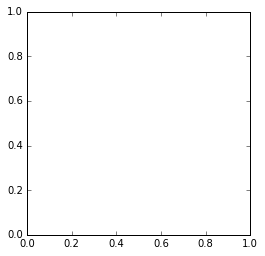

In [14]:
plt.imshow(out)

In [ ]:
class Loss(nn.Module):
    def __init__(self,loss_name):
        super(Loss,self).__init__()
        self.mse = nn.MSELoss()
        self.l1  = nn.L1Loss()
        self.loss_name = loss_name
        self.psnr = PSNR()
        self.ssim = SSIM3D(window_size = 11)
        
    def forward(self,yhat,y):
        if self.loss_name == "RMSE":
            return torch.sqrt(self.mse(yhat,y))
        elif self.loss_name == "MSE":
            return self.mse(yhat,y)
        elif self.loss_name == "L1Loss":
            return self.l1(yhat,y)
        elif self.loss_name == "PSNR":
            return self.psnr(yhat,y)
        elif self.loss_name == "SSIM":
            return 1-self.ssim(yhat,y)